In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, load_npz, save_npz, vstack
import seaborn as sns
import matplotlib.pyplot as plt
import json
from concurrent.futures import ProcessPoolExecutor, as_completed
import anndata
import scanpy as sc
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
See here https://stackoverflow.com/questions/52371329/fast-spearman-correlation-between-two-pandas-dataframes

Calculate correlation between two matrix, row by row
"""

from numba import njit
import numpy as np


@njit
def _mean(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].mean()
    return b


@njit
def _std(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].std()
    return b


@njit
def _corr(a, b):
    """
    Correlation between rows in a and b, no nan value
    """
    n, k = a.shape
    m, k = b.shape

    mu_a = _mean(a)
    mu_b = _mean(b)
    sig_a = _std(a)
    sig_b = _std(b)

    out = np.empty((n, m))

    for i in range(n):
        for j in range(m):
            _sig_a = sig_a[i]
            _sig_b = sig_b[j]
            if _sig_a == 0 or _sig_b == 0:
                # if any variable std == 0
                out[i, j] = np.nan
            else:
                out[i, j] = (a[i] - mu_a[i]) @ (b[j] -
                                                mu_b[j]) / k / _sig_a / _sig_b
    return out


def corr(a, b, method='pearson'):
    if method.lower()[0] == 'p':
        pass
    elif method.lower()[0] == 's':
        # turn a, b in to rank matrix
        a = a.argsort(axis=1).argsort(axis=1)
        b = b.argsort(axis=1).argsort(axis=1)
    else:
        raise ValueError('Method can only be pearson or spearman')

    return _corr(a, b)


def chunk_corr(dmr_data, gene_data, cutoff):
    record = corr(a=dmr_data, b=gene_data)
    record[np.abs(record) < cutoff] = 0
    pass_record = csr_matrix(record)
    return pass_record

In [3]:
chrom = 'chr16'
chunk_size = 1000
cpu = 40
mask_dir = 'DMR_gene_10M_mask'

# generate null
dmr_sample = 5000
repeat = 200

# sig corr
cutoff = 0

In [4]:
# Parameters
chrom = "chr4"


## Load Data

In [5]:
dmr_df = pd.read_msgpack(
    f'/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/DMR_rate/SubDMR_rate_no_na.{chrom}.msg'
)
gene_df = pd.read_msgpack(
    f'/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/Gene-slop2k-mCH/SubDMR_rate_no_na.{chrom}.msg'
)

with open(
        f'/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/{mask_dir}/{chrom}.gene_int.json'
) as f:
    gene_to_int = json.load(f)

# reindex gene_df
reindex = gene_df.index.map(gene_to_int).argsort()
gene_df = gene_df.iloc[reindex].copy()

dmr_df.columns = dmr_df.columns.map(lambda i: i.replace('_', ' '))
use_cols = dmr_df.columns & gene_df.columns

dmr_df = dmr_df[use_cols].copy()
gene_df = gene_df[use_cols].copy()

cluster_mcg = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/ClusterGlobalmCG.csv',
    index_col=0,
    header=None,
    squeeze=True).loc[use_cols]
cluster_mch = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/ClusterGlobalmCH.csv',
    index_col=0,
    header=None,
    squeeze=True).loc[use_cols]

# standardize global
cluster_mcg = (cluster_mcg - cluster_mcg.mean()) / cluster_mcg.std()
cluster_mch = (cluster_mch - cluster_mch.mean()) / cluster_mch.std()

print(dmr_df.shape[0], 'DMRs')
print(gene_df.shape[0], 'Genes')

283201 DMRs
2871 Genes


## Regress Out DMR global corr
- Global mCH
- Global mCG

In [6]:
dmr_adata = anndata.AnnData(X=dmr_df.values.T,
                obs=pd.DataFrame([], index=dmr_df.columns),
                var=pd.DataFrame([], index=dmr_df.index))

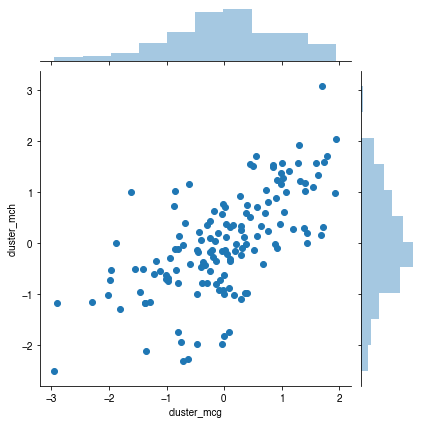

In [7]:
dmr_adata.obs['cluster_mch'] = cluster_mch
dmr_adata.obs['cluster_mcg'] = cluster_mcg

sns.jointplot(x=dmr_adata.obs['cluster_mcg'], y=dmr_adata.obs['cluster_mch'])

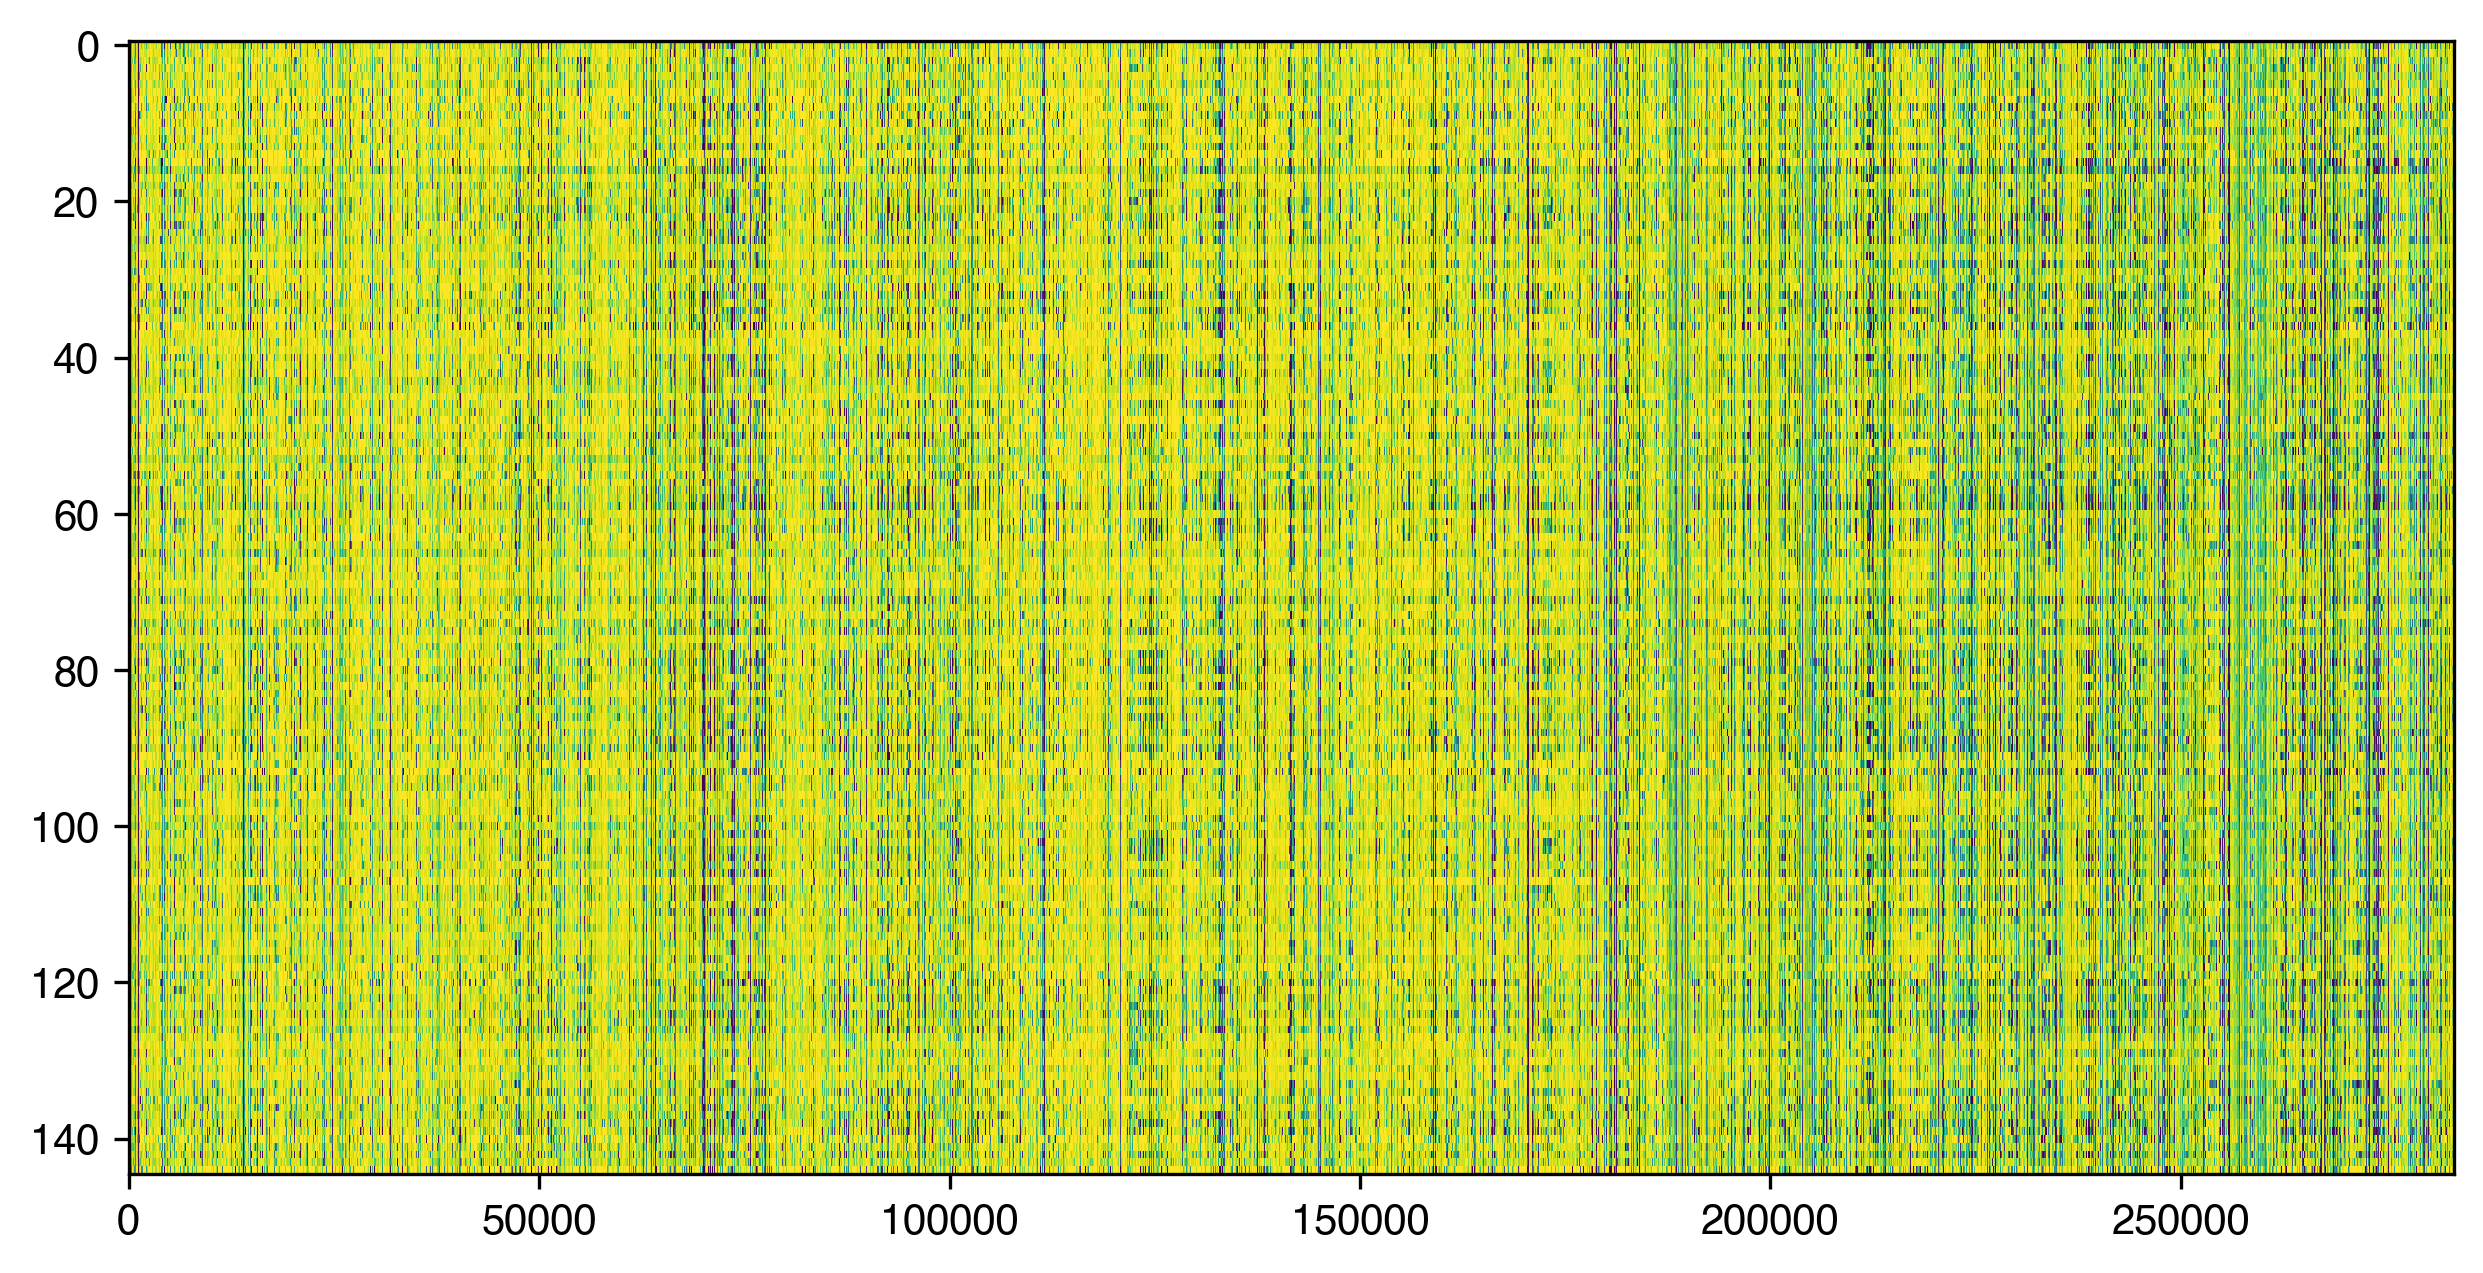

In [8]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(dmr_adata.X, aspect='auto', vmin=0, vmax=1)

In [9]:
# remove dmr that has 0 std
# otherwise regress out will fail.
dmr_adata = dmr_adata[:, dmr_adata.X.std(axis=0) > 0].copy()


In [10]:
sc.pp.regress_out(dmr_adata, 
                  keys=['cluster_mch', 'cluster_mcg'], 
                  n_jobs=cpu)

In [11]:
scaler = StandardScaler(copy=False)
dmr_adata.X = scaler.fit_transform(dmr_adata.X)

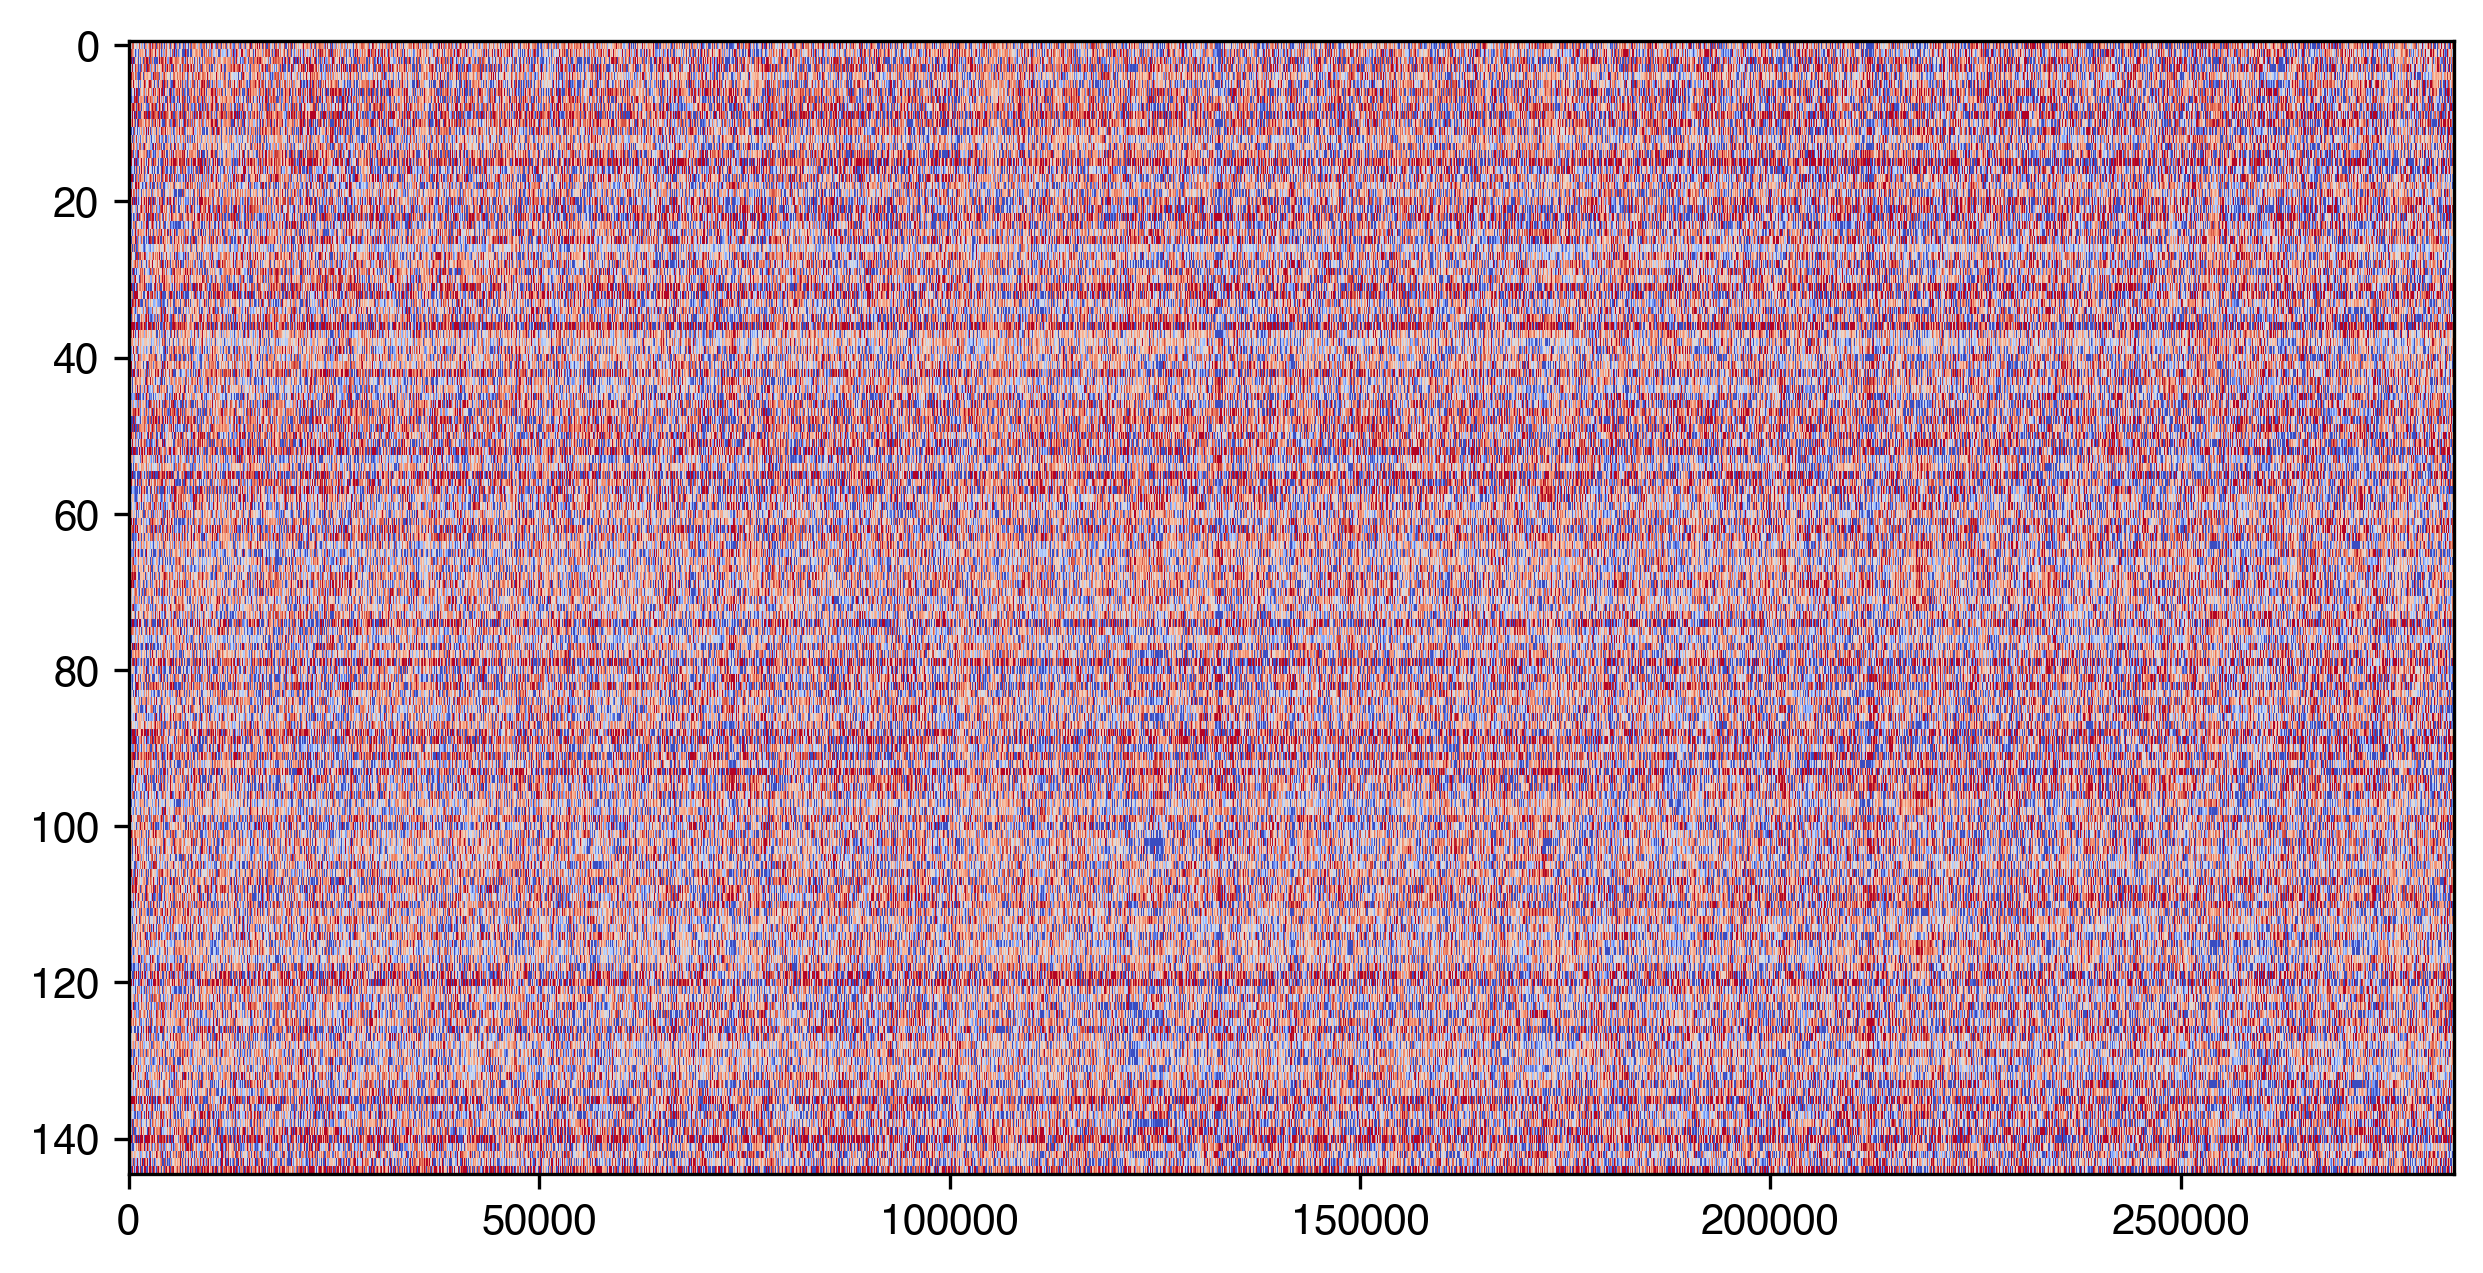

In [12]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(dmr_adata.X, aspect='auto', cmap='coolwarm', 
           vmin=-1, vmax=1)

## Regress Out Gene Global Corr

In [13]:
gene_adata = anndata.AnnData(X=gene_df.values.T,
                obs=pd.DataFrame([], index=gene_df.columns),
                var=pd.DataFrame([], index=gene_df.index))

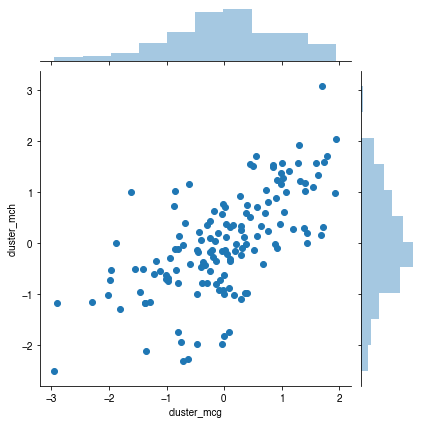

In [14]:
gene_adata.obs['cluster_mch'] = cluster_mch
gene_adata.obs['cluster_mcg'] = cluster_mcg

sns.jointplot(x=gene_adata.obs['cluster_mcg'], 
              y=gene_adata.obs['cluster_mch'])

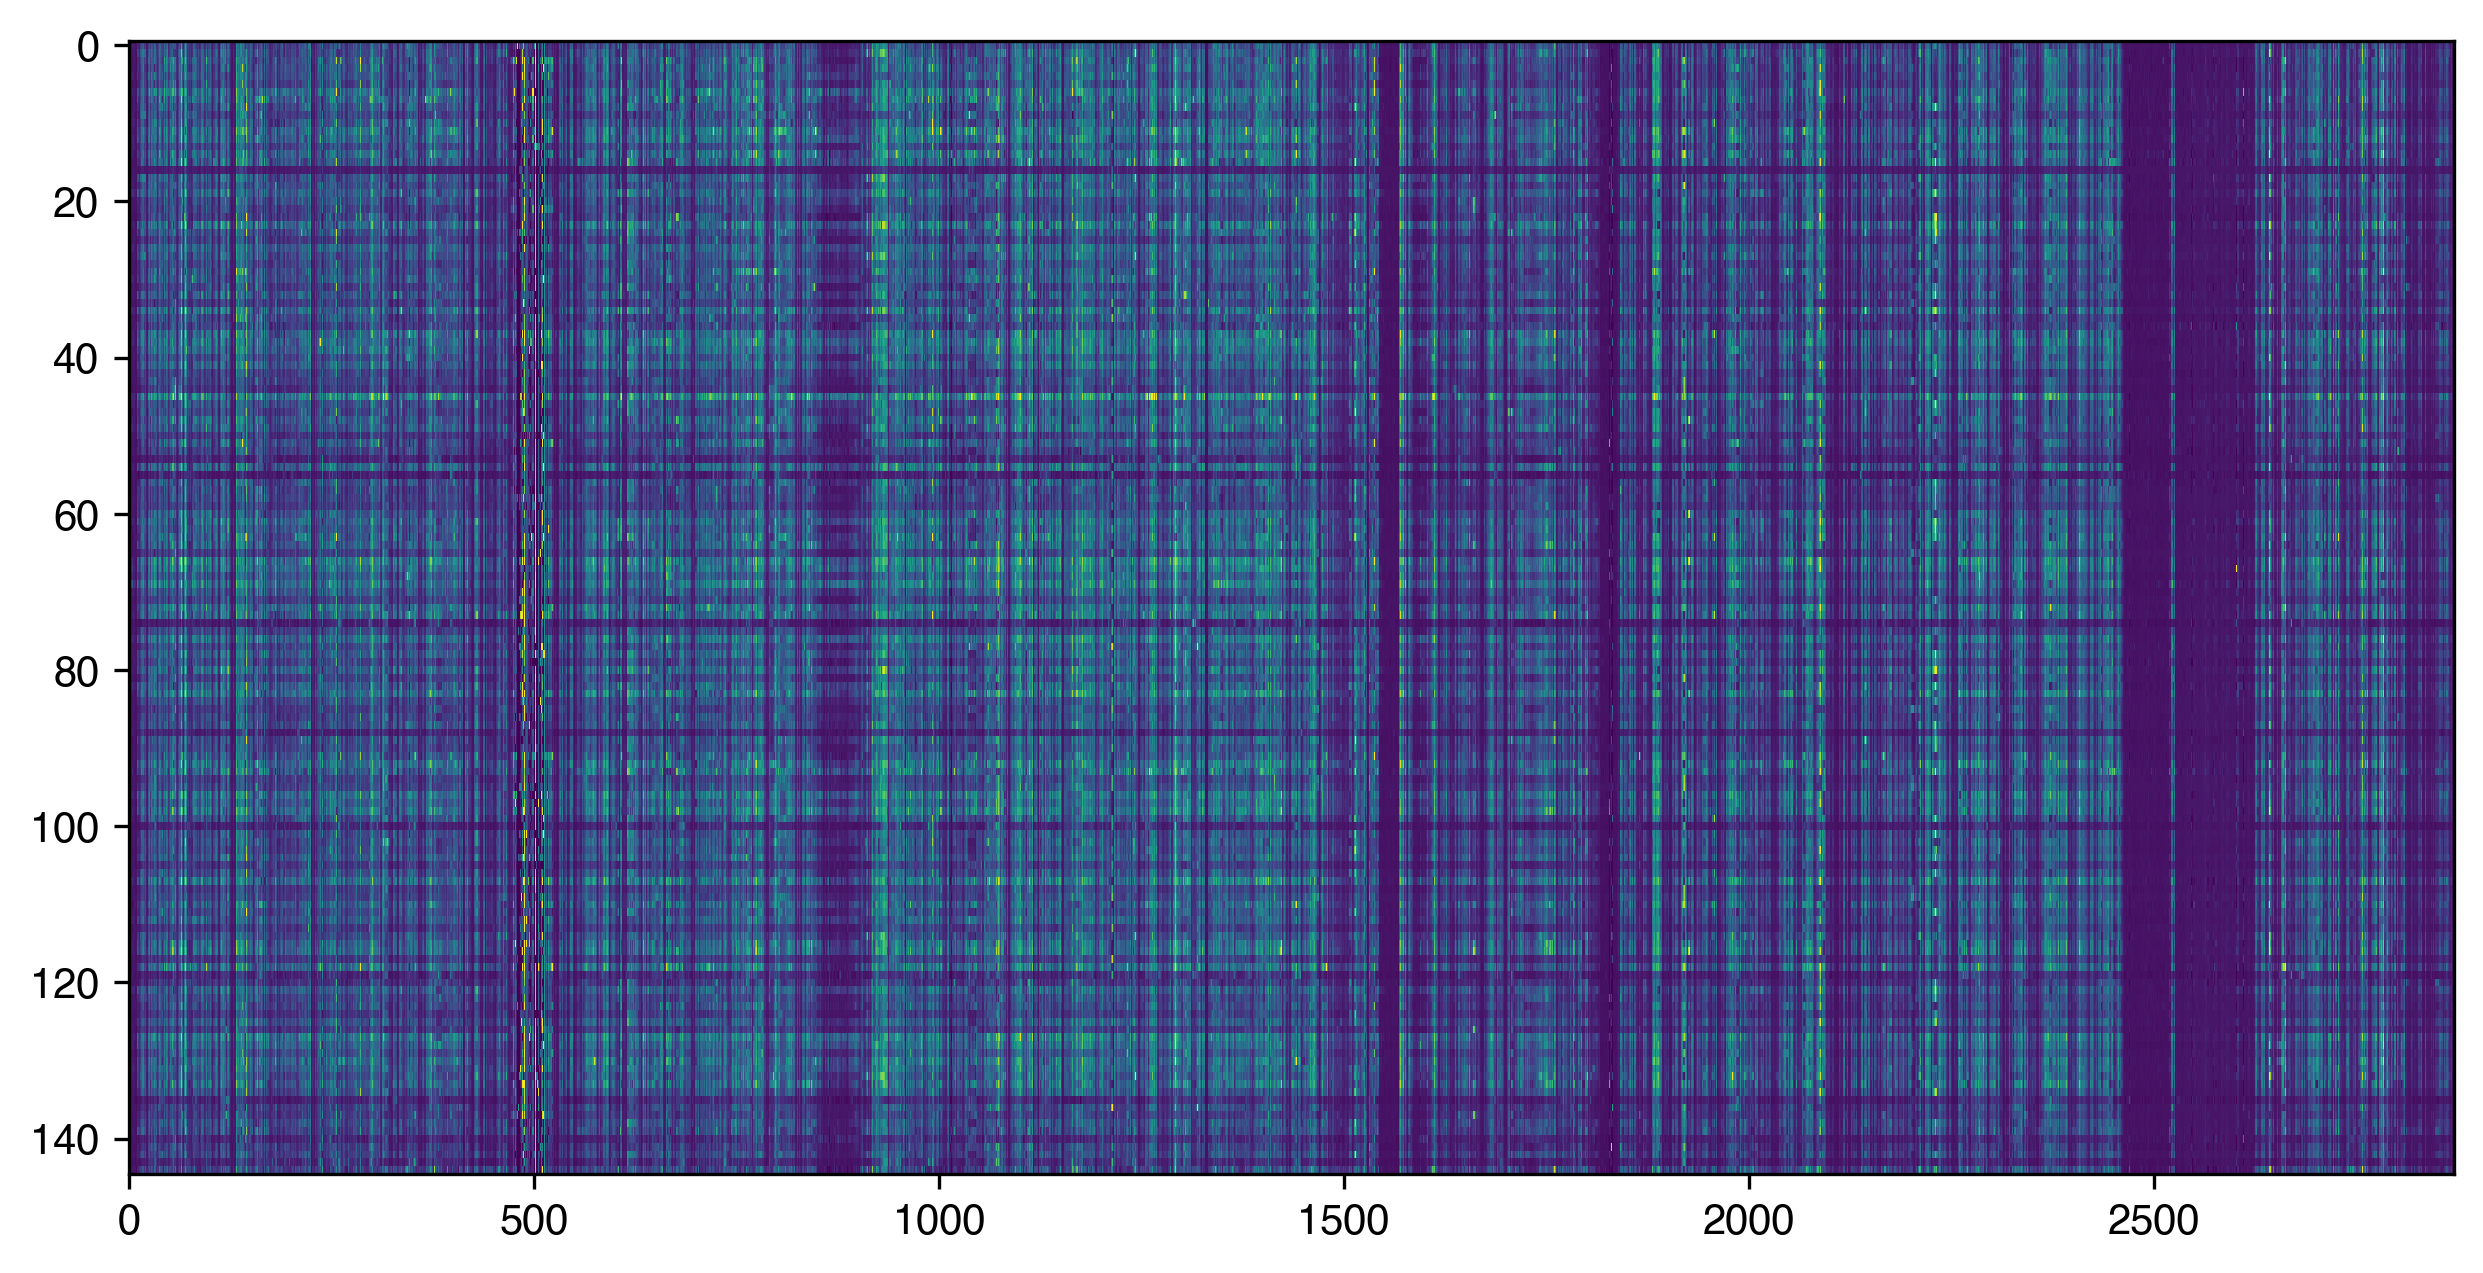

In [15]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(gene_adata.X, aspect='auto', vmin=0, vmax=0.1)

In [17]:
# remove dmr that has 0 std
# otherwise regress out will fail.
gene_adata = gene_adata[:, gene_adata.X.std(axis=0) > 0].copy()

In [ ]:
sc.pp.regress_out(gene_adata, 
                  keys=['cluster_mch', 'cluster_mcg'], 
                  n_jobs=cpu)

In [ ]:
scaler = StandardScaler(copy=False)
gene_adata.X = scaler.fit_transform(gene_adata.X)

In [ ]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(gene_adata.X, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

## Calculate residual Corr

In [ ]:
use_gene = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorrFor3C/input_regions/use_genes.txt',
                       header=None, index_col=0).index
use_dmr = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorrFor3C/input_regions/use_dmrs.txt',
                       header=None, index_col=0).index


In [ ]:
gene_adata = gene_adata[:, gene_adata.var_names & use_gene].copy()
dmr_adata = dmr_adata[:, dmr_adata.var_names & use_dmr].copy()


gene_data = gene_adata.X.T
total_dmr_data = dmr_adata.X.T

results = []
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for i, chunk_start in enumerate(range(0, total_dmr_data.shape[0], chunk_size)):
        dmr_data = total_dmr_data[chunk_start:chunk_start+chunk_size, :]
        future = executor.submit(chunk_corr,
                                 dmr_data=dmr_data, 
                                 gene_data=gene_data,
                                 cutoff=cutoff)
        futures[future] = i

    results = {}
    for future in as_completed(futures):
        chunk_id = futures[future]
        pass_record = future.result()
        results[chunk_id] = pass_record

# final concat
final_adata = anndata.AnnData(vstack((results[i] for i in range(len(results)))), 
                              obs=dmr_adata.var.copy(), 
                              var=gene_adata.var.copy())
final_adata

## Calculate Null Dist

In [ ]:
# # row is cluster
# shuffled_gene_data_T = gene_data.T.copy()
# shuffled_dmr_data_T = total_dmr_data.T.copy()

In [ ]:
# # shuffle axis 0 inplace
# with ProcessPoolExecutor(cpu) as executor:
#     futures = {}
#     results = []
#     for _ in range(repeat):
#         # shuffle axis 0 in each repeat
#         np.random.shuffle(shuffled_gene_data_T)
#         np.random.shuffle(shuffled_dmr_data_T)
#         
#         # downsample DMR data, no need to use full DMR list to calc null
#         if shuffled_dmr_data_T.shape[1] > dmr_sample:
#             indices = np.random.choice(shuffled_dmr_data_T.shape[1], dmr_sample, replace=False)
#             this_dmrs = shuffled_dmr_data_T[:, indices]
#             this_mask = dist_mask[indices, :]
#         else:
#             this_mask = dist_mask
#             this_dmrs = shuffled_dmr_data_T
#         mask = dist_mask[chunk_start:chunk_start+chunk_size, :]
#     
#         future = executor.submit(chunk_corr,
#                                  dmr_data=this_dmrs.T, 
#                                  gene_data=shuffled_gene_data_T.T, 
#                                  mask=this_mask,
#                                  cutoff=0)
#         futures[future] = i
# 
#     for future in as_completed(futures):
#         chunk_id = futures[future]
#         masked_pass_record = future.result()
#         results.append(masked_pass_record)
# 
# # final concat
# final_null_result = vstack(results)

In [ ]:
# sns.distplot(np.random.choice(final_null_result.data, 10000, replace=False))

In [ ]:
# p_values = {}
# for i in np.arange(0.3, 1, 0.005):
#     total_n = final_null_result.data.size
#     p = (final_null_result > i).sum() / total_n
#     p_values[i] = p
# p_values = pd.Series(p_values)
# p_values = -np.log10(p_values)
# p_values.replace(np.inf, 10, inplace=True)

In [ ]:
# cutoff = p_values[p_values > neg_logp_cutoff].index[0]
cutoff

In [ ]:
fig = plt.figure(figsize=(5, 10), dpi=300)
plt.imshow(final_adata.X.todense(), cmap='coolwarm',
           aspect='auto', vmin=-1, vmax=1)

In [ ]:
sns.distplot(final_adata.X.data, kde=False, bins=100)

In [ ]:
final_adata.X = final_adata.X.multiply(np.abs(final_adata.X) > cutoff)

In [ ]:
(final_adata.X.data > 0).sum(), (final_adata.X.data < 0).sum()

In [ ]:
(final_adata.X.data > 0.5).sum(), (final_adata.X.data < -0.5).sum()

In [ ]:
final_adata.write_h5ad(f'{chrom}.h5ad')

In [ ]:
final_adata